## Basic CNN classifier to clasify images in the CIFAR-10 dataset using PyTorch

### Library imports:

In [1]:
import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data

import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import warnings

### Loading dataset and setting transformations:

In [2]:
transformations = transforms.Compose([
    # convert PILImage to Tensors
    transforms.ToTensor(),
    
    # normalise the tensor values to a mean of 0.5 and standdard deviation of 0.5
    # for each of the 3 color channels of the input RGB image
    # transforms.Normalize(mean, std); mean = sequence, std = sequence
    transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
])

trainset = torchvision.datasets.CIFAR10( root = "./data", train = True, transform = transformations, download = True )
testset = torchvision.datasets.CIFAR10( root = "./data", train = False, transform = transformations, download = True )

trainsetloader = data.DataLoader( trainset, batch_size = 30, num_workers = 2, shuffle = True )
testsetloader = data.DataLoader( testset, batch_size = 30, num_workers = 2, shuffle = False )

classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Files already downloaded and verified
Files already downloaded and verified


### Sample plot of an image from trainset:

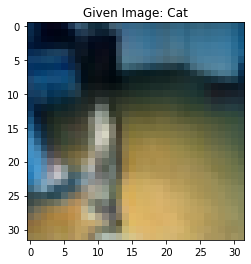

In [3]:
# Plotting a sample image

def plot_image(img, label):
    img = img / 2 + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title( "Given Image: " + classes[label.item()] )
    plt.show()

traindata_iter = iter(trainsetloader)
image, label = traindata_iter.next()
image_num = 10 #between 0-29

plot_image( torchvision.utils.make_grid(image[image_num]), label[image_num] )

### Define the Convolutional Neural Network:
**conv1:**
- Input: 3 channel image input of **32x32**
- Kernel size: **5x5**
- Output: 6 feature maps of **28x28**

**pool1:**
- Input: feature maps of **28x28**
- Kernel size: **2x2**
- Stride: **2**
- Output: 6 feature maps of **14x14**

**conv2:**
- Input: feature maps of **14x14**
- Kernel size: **5x5**
- Output: 16 feature maps of **10x10**

**pool2 (same as pool1, defined separately for clarity):**
- Input: feature maps of **10x10**
- Kernel size: **2x2**
- Stride: **2**
- Output: 16 feature maps of **5x5**

**flatten the previous layers output to tensor dimension (1, 16x5x5)**

**fc1, fc2, fc3:**
- Initial **16x5x5** nodes and ends with **10** nodes for 10 classes.

In [32]:
# Make the CNN:

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16*5*5, 150)
        self.fc2 = nn.Linear(150, 75)
        self.fc3 = nn.Linear(75, 10)
    
    def forward(self, inp):
        conv1_out = functional.relu( self.conv1(inp) )
        pool1_out = self.pool( conv1_out )
        
        conv2_out = functional.relu( self.conv2(pool1_out) )
        pool2_out = self.pool( conv2_out )
        
        # flatten:
        pool2_out = pool2_out.view(-1, 16*5*5)
        fc1_out = functional.relu( self.fc1( pool2_out ) )
        fc2_out = functional.relu( self.fc2(fc1_out) )
        fc3_out = self.fc3( fc2_out )
        
        return fc3_out

### Train the network:

In [33]:
network = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.1)

print("--------Training Start--------")
num_epochs = 10

for epoch in range(1, num_epochs+1):
    current_loss = 0
    
    for i, batch in enumerate(trainsetloader):
        # get images and labels from single batch
        images, labels = batch
        
        # zero out the gradients at start of each batch
        optimizer.zero_grad()
        
        # make a prediction
        predictions = network(images)
        
        # calculate loss using criterion
        loss = criterion(predictions, labels)
        
        # calculate gradients
        loss.backward()
        
        # backpropogate update
        optimizer.step()
        
        # add up running loss for reporting after each epoch
        current_loss += loss.item()
    
    print("Epoch #", epoch, "\tRunning loss: ", current_loss/len(trainsetloader))

print("--------Training Done--------")

--------Training Start--------
Epoch # 1 	Running loss:  1.734356521630473
Epoch # 2 	Running loss:  1.3777812671790097
Epoch # 3 	Running loss:  1.2360579430806686
Epoch # 4 	Running loss:  1.1372590530898374
Epoch # 5 	Running loss:  1.0667185572070423
Epoch # 6 	Running loss:  1.0095641802511461
Epoch # 7 	Running loss:  0.9662743794860851
Epoch # 8 	Running loss:  0.9299344800157896
Epoch # 9 	Running loss:  0.8928988044606617
Epoch # 10 	Running loss:  0.8684819734554199
--------Training Done--------


### Save the model:

In [34]:
model_path = "./models/"
lenet_cnn_directory = "LeNet/lenet_cifar10.pth"

In [35]:
torch.save( network.state_dict(), model_path + lenet_cnn_directory )

### Get saved model:

**Useful when resuming work in notebook. Network parameters can be loaded from file, training can be skipped.**

In [37]:
network = LeNet()
network.load_state_dict( torch.load(model_path + lenet_cnn_directory) )

<All keys matched successfully>

### Test the model and get accuracy on test set:

In [38]:
with torch.no_grad():
    total_count = 0
    total_correct = 0
    for i, batch in enumerate(testsetloader):
        test_images, test_labels = batch
        
        predictions = network(test_images)
        value, predict = torch.max(predictions, 1)
        
        batch_count = test_labels.shape[0]
        batch_correct = (predict==test_labels).sum().item()
        total_count += batch_count
        total_correct += batch_correct
        
        print("\nBatch #", i)
        print("Predict: ", predict.numpy())
        print("Acctual: ", test_labels.numpy())
        print("Batch Accuracy: ", ((batch_correct*100)/batch_count))
    
    print("\nFinal accuracy: ", ((total_correct*100)/total_count))


Batch # 0
Predict:  [3 8 8 0 6 6 5 6 5 1 0 9 4 7 9 8 5 3 8 4 5 2 0 9 4 2 4 2 9 6]
Acctual:  [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6]
Batch Accuracy:  66.66666666666667

Batch # 1
Predict:  [3 5 4 5 9 6 7 1 9 5 0 6 5 6 0 9 3 5 4 2 0 8 6 3 8 8 5 5 5 5]
Acctual:  [6 5 4 5 9 2 4 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 0 3 8 8 7 7 4 6]
Batch Accuracy:  56.666666666666664

Batch # 2
Predict:  [7 5 1 2 6 2 8 0 5 7 8 5 8 8 0 2 7 5 5 8 8 1 1 2 5 2 2 8 8 9]
Acctual:  [7 3 6 3 6 2 1 2 3 7 2 6 8 8 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9]
Batch Accuracy:  50.0

Batch # 3
Predict:  [0 3 8 6 4 5 6 0 7 2 4 5 2 3 1 8 0 6 0 5 5 0 6 2 1 2 0 4 3 5]
Acctual:  [0 3 8 6 4 6 6 0 0 7 4 5 6 3 1 1 3 6 8 7 4 0 6 2 1 3 0 4 2 7]
Batch Accuracy:  60.0

Batch # 4
Predict:  [8 2 1 2 8 1 8 3 6 8 4 1 8 9 3 3 9 7 4 8 3 5 3 3 8 7 6 5 5 5]
Acctual:  [8 3 1 2 8 0 8 3 5 2 4 1 8 9 1 2 9 7 2 9 6 5 6 3 8 7 6 2 5 2]
Batch Accuracy:  60.0

Batch # 5
Predict:  [8 0 3 0 0 5 5 9 3 4 0 1 5 6 8 7 8 4 9 0 9 9 0 8 9 9 4 7 5 9]
Acctu


Batch # 69
Predict:  [2 9 5 2 2 7 3 8 6 0 8 3 2 5 7 0 9 0 7 7 5 2 1 6 5 0 9 2 0 1]
Acctual:  [2 9 6 2 2 4 3 0 2 0 1 3 2 2 7 0 1 0 7 7 2 0 1 6 5 0 2 2 0 1]
Batch Accuracy:  66.66666666666667

Batch # 70
Predict:  [2 6 9 1 6 6 5 5 3 0 7 9 1 0 2 5 9 7 8 6 5 6 0 2 0 1 1 5 6 2]
Acctual:  [2 6 0 1 6 6 5 3 4 0 0 9 1 0 2 5 9 7 8 6 4 6 0 2 0 1 9 2 4 9]
Batch Accuracy:  70.0

Batch # 71
Predict:  [2 5 2 3 5 8 9 4 6 8 9 7 0 9 3 4 2 7 9 6 9 5 7 8 5 8 8 3 9 7]
Acctual:  [0 7 2 3 4 8 0 2 6 8 9 7 1 9 3 7 2 7 9 6 9 5 7 8 5 9 8 3 9 8]
Batch Accuracy:  70.0

Batch # 72
Predict:  [8 5 9 7 1 2 0 5 5 8 2 5 0 3 9 9 8 9 9 1 4 8 4 6 9 0 1 6 9 2]
Acctual:  [0 5 5 7 1 2 0 7 5 8 2 2 5 3 9 3 1 9 3 1 4 3 4 4 9 0 9 5 9 2]
Batch Accuracy:  60.0

Batch # 73
Predict:  [1 5 4 0 8 5 8 6 8 5 0 5 9 6 9 5 0 6 4 8 2 7 2 6 4 7 5 8 4 5]
Acctual:  [9 4 0 2 8 4 8 6 8 2 0 5 9 6 9 5 1 3 4 4 2 7 2 4 4 0 2 8 4 5]
Batch Accuracy:  60.0

Batch # 74
Predict:  [1 4 6 8 1 7 5 8 7 4 5 5 3 4 0 2 5 3 1 4 9 0 3 3 9 8 1 5 8 0]
Acctual:  [1 

Predict:  [1 5 6 7 3 7 6 8 8 9 3 6 1 0 7 5 8 0 1 5 8 1 4 6 5 0 4 8 9 5]
Acctual:  [1 5 6 6 2 4 6 8 8 9 6 6 1 0 7 5 8 2 1 5 8 1 4 7 5 0 3 9 9 5]
Batch Accuracy:  73.33333333333333

Batch # 132
Predict:  [5 8 4 2 8 0 2 4 8 2 9 0 7 9 8 7 1 6 5 9 9 8 9 2 6 7 7 1 1 2]
Acctual:  [2 8 4 1 9 0 4 4 8 2 9 0 7 9 8 7 1 3 2 9 9 5 9 7 6 7 7 1 1 2]
Batch Accuracy:  73.33333333333333

Batch # 133
Predict:  [4 5 0 6 8 5 7 6 2 9 0 4 5 0 0 5 8 3 8 2 5 7 9 9 8 1 6 5 9 7]
Acctual:  [4 2 0 6 8 7 6 2 2 9 8 2 4 2 0 5 8 6 8 2 7 7 3 1 8 1 6 5 9 7]
Batch Accuracy:  60.0

Batch # 134
Predict:  [8 9 6 5 8 8 9 4 0 4 1 2 5 6 2 2 8 0 1 7 0 7 0 4 6 7 7 4 5 4]
Acctual:  [8 9 6 4 8 1 9 4 0 4 1 4 3 6 2 2 7 0 0 7 0 7 4 3 6 7 7 4 5 4]
Batch Accuracy:  73.33333333333333

Batch # 135
Predict:  [3 5 5 4 0 8 0 7 7 1 6 5 8 7 7 4 2 1 8 5 9 8 5 6 5 4 7 5 5 8]
Acctual:  [3 5 5 4 7 1 0 7 7 1 6 5 0 7 7 4 6 1 8 5 9 3 5 6 2 2 7 3 5 8]
Batch Accuracy:  73.33333333333333

Batch # 136
Predict:  [1 9 6 8 7 3 8 5 2 3 2 9 4 3 5 8 8 4 1 3 7 

Batch # 194
Predict:  [5 5 5 5 0 5 3 0 5 4 6 5 9 2 5 5 8 5 7 5 2 6 9 6 8 5 5 8 7 2]
Acctual:  [5 8 3 5 7 3 7 0 5 4 5 6 9 3 5 3 8 2 4 2 2 6 7 6 0 5 5 8 4 5]
Batch Accuracy:  46.666666666666664

Batch # 195
Predict:  [5 1 3 5 4 2 5 0 7 2 8 9 5 4 1 6 4 5 9 7 7 3 5 5 6 1 6 9 5 8]
Acctual:  [6 1 3 5 4 7 3 0 7 2 0 1 2 4 9 6 4 5 9 7 7 6 7 4 3 1 6 9 4 8]
Batch Accuracy:  60.0

Batch # 196
Predict:  [0 5 9 3 5 4 5 1 5 2 5 0 8 0 5 6 9 4 8 1 5 5 0 3 7 1 4 5 7 1]
Acctual:  [0 3 1 6 4 4 2 1 4 6 3 0 8 9 7 6 8 4 8 1 4 5 9 4 7 1 4 5 3 1]
Batch Accuracy:  50.0

Batch # 197
Predict:  [5 6 9 7 1 3 9 2 9 0 8 2 4 0 5 5 0 2 7 7 7 5 6 4 5 6 5 9 9 9]
Acctual:  [2 6 4 7 1 5 9 3 1 4 8 7 7 0 4 3 4 6 7 7 5 4 4 4 3 6 6 1 9 9]
Batch Accuracy:  40.0

Batch # 198
Predict:  [3 9 4 5 2 7 8 5 0 6 1 0 9 5 8 8 2 2 9 8 6 3 6 2 9 7 9 9 0 5]
Acctual:  [7 9 4 3 2 9 8 5 0 6 9 0 9 7 8 5 4 4 9 4 2 6 6 9 9 7 9 9 0 5]
Batch Accuracy:  60.0

Batch # 199
Predict:  [1 1 0 6 9 9 5 6 5 8 9 7 9 4 0 4 5 5 9 8 8 5 4 8 7 8 2 0 5 0]
Acctual

Batch # 256
Predict:  [5 0 8 0 2 1 1 2 8 0 6 6 0 7 9 0 0 5 0 7 6 0 4 7 9 5 8 8 2 5]
Acctual:  [3 0 8 0 0 9 9 6 8 0 6 6 0 7 9 8 0 5 0 9 6 0 4 7 1 7 8 8 2 3]
Batch Accuracy:  66.66666666666667

Batch # 257
Predict:  [9 2 5 3 3 1 5 0 0 5 5 2 3 6 8 4 5 7 1 9 5 1 7 0 9 8 4 0 2 9]
Acctual:  [9 6 5 5 3 1 5 3 0 2 5 2 7 3 8 4 4 6 1 9 4 1 7 0 1 4 3 0 2 9]
Batch Accuracy:  60.0

Batch # 258
Predict:  [4 5 8 3 3 5 0 3 0 0 6 4 9 1 0 7 5 6 7 1 9 3 7 4 6 8 6 9 8 7]
Acctual:  [4 5 0 3 4 7 2 3 0 1 3 7 9 9 0 7 5 6 7 1 2 2 7 4 6 8 4 9 8 4]
Batch Accuracy:  60.0

Batch # 259
Predict:  [9 2 3 4 0 5 5 6 3 5 8 5 8 5 2 7 9 5 6 7 8 2 1 8 6 5 8 4 3 9]
Acctual:  [9 2 3 4 0 2 5 6 0 5 3 5 8 3 7 4 9 5 6 3 8 6 9 8 5 5 8 3 5 9]
Batch Accuracy:  60.0

Batch # 260
Predict:  [0 2 3 8 5 9 9 5 8 0 6 0 4 0 7 8 4 5 9 8 5 0 4 7 9 3 9 5 5 8]
Acctual:  [0 4 2 0 5 9 9 3 8 0 6 0 2 3 7 0 0 6 9 1 5 2 2 7 9 3 9 3 5 2]
Batch Accuracy:  53.333333333333336

Batch # 261
Predict:  [9 4 8 8 5 0 0 7 0 5 1 6 5 0 9 2 3 2 4 0 0 0 7 5 3 5 6 4


Batch # 316
Predict:  [2 5 0 0 9 7 4 1 6 6 8 8 9 0 8 0 1 2 6 0 9 0 6 6 6 5 7 8 8 3]
Acctual:  [2 2 0 0 0 7 4 1 6 6 8 8 9 0 9 0 1 3 3 0 9 6 6 2 6 3 4 0 8 4]
Batch Accuracy:  63.333333333333336

Batch # 317
Predict:  [1 6 0 9 1 9 9 1 1 9 8 4 4 5 4 2 0 3 0 5 6 6 8 0 6 4 5 6 9 8]
Acctual:  [1 4 0 6 5 0 9 9 9 9 1 2 3 5 4 2 9 6 0 9 6 6 8 0 6 1 4 6 8 0]
Batch Accuracy:  46.666666666666664

Batch # 318
Predict:  [5 5 1 5 0 9 6 4 5 4 6 5 1 7 7 3 1 2 0 9 1 1 8 5 9 0 9 2 8 2]
Acctual:  [5 4 1 2 0 9 6 4 2 4 6 5 9 7 7 4 6 5 0 1 9 0 3 1 9 0 9 7 8 6]
Batch Accuracy:  53.333333333333336

Batch # 319
Predict:  [7 6 8 5 4 5 5 0 3 2 1 7 5 0 3 4 5 7 1 5 0 1 1 5 9 7 5 4 1 7]
Acctual:  [7 6 8 2 4 5 3 0 3 2 1 7 5 9 3 4 5 7 1 5 0 1 1 1 9 7 5 4 9 7]
Batch Accuracy:  83.33333333333333

Batch # 320
Predict:  [8 3 0 2 8 5 8 4 0 0 4 8 0 2 6 6 2 8 1 8 7 6 2 9 2 0 1 4 9 1]
Acctual:  [8 1 0 2 8 5 6 7 0 1 4 8 4 4 6 6 5 8 1 8 4 6 5 9 2 2 1 4 9 1]
Batch Accuracy:  66.66666666666667

Batch # 321
Predict:  [5 7 2 0 1 4 2

### Sample plot of a test image aloing with network's prediction:

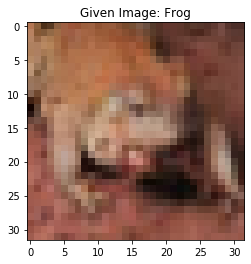

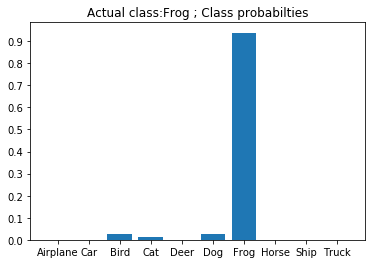

In [39]:
with torch.no_grad():
    testsetiter = iter(testsetloader)
    test_images, test_labels = next(testsetiter)
    
    # can be anything between 0-29 (a batch is of 30 images)
    image_id = 5
    
    # plot test image
    plot_image( torchvision.utils.make_grid(test_images[image_id]), test_labels[image_id] )
    
    # bar plot result probabilities
    predictions = network(test_images)
    log_softmax_out = functional.log_softmax(predictions, dim = 1)
    probabilities = torch.exp(log_softmax_out)
    probs = probabilities.numpy()[image_id]
    
    plt.bar(classes, probs)
    plt.title("Actual class:" + classes[test_labels[image_id]] + " ; Class probabilties")
    plt.yticks( (np.arange(0, 1, step = 0.1)) )
    plt.show()